# Twitter NLP Project

Morgan Nash

November 2025

The presence of social media today allows for instant communication which presents problems for companies to deal with and address. "Cancel culture" continues to create the challenge of massive volumes and rapid escalations of social media complaints. Ineffective monitoring leads to slow crisis response, missed customer service opportunities, and permanent brand damage. 

#### Goal of Implementing an NLP Model:
To provide any business with a highly effective Real-Time Screening System capable of
- Immediate Crisis Detection: Instantly identifying and routing urgent, negative sentiments online related to products, services, or brand actions.
- Operational Efficiency: Quantifying public opinion to prioritize support tickets and allocate resources efficiently, moving from reactive chaos to proactive management.


Multiclass Target: Negative, Neutral, Positive

"The notebook should include a summary at the beginning that briefly and accurately describes your process. The summary should be approximately 250 words -- about the size of a research paper abstract.

Summary elements:

Business and data understanding: what kind of data are you using, and what makes it well-suited for the business problem?
You do not need to include any data visualizations in your summary, but consider including relevant descriptive statistics
Data preparation: why did you choose the data preparation steps that you did, and what was the result?
This should be specific to the kind of data you are working with. For example, if you are doing an NLP project, what did you decide to do with stopwords?
Be sure to list the packages/libraries used to prepare the data, and why
Modeling: what modeling package(s) did you use, which model(s) within the package(s), and what tuning steps did you take?
For some projects there may be only one applicable package; you should still briefly explain why this was the appropriate choice
Evaluation: how well did your final model perform?
Include one or more relevant metrics
Be sure to briefly describe your validation approach"

# Objective

"Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion. Added: August 30, 2013 by Kent Cavender-Bares | Data Rows: 9093 Download Now" from data.world

- TASK Topic 3: Natural Language Processing (NLP)
- If you choose this option, you'll build an NLP model to analyze Twitter sentiment about Apple and Google products. The dataset comes from CrowdFlower via data.world. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither.

- Your task is to:

- Build a model that can rate the sentiment of a Tweet based on its content.

- Aim for a Proof of Concept
- There are many approaches to NLP problems - start with something simple and iterate from there. For example, you could start by limiting your analysis to positive and negative Tweets only, allowing you to build a binary classifier. Then you could add in the neutral Tweets to build out a multiclass classifier.

- Evaluation
- Evaluating multiclass classifiers can be trickier than binary classifiers because there are multiple ways to mis-classify an observation, and some errors are more problematic than others. Use the business problem that your NLP project sets out to solve to inform your choice of evaluation metrics.

## Data Preparation

In [18]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from nltk import FreqDist
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

In [2]:
#load and preview dataset
data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin-1')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
#rename columns (the original labels are bulky)
data = data.rename(columns = {'tweet_text': 'tweet', 
                         'emotion_in_tweet_is_directed_at': 'product_name', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}) 
data.head() 

,tweet,product_name,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet         9092 non-null   object
 1   product_name  3291 non-null   object
 2   sentiment     9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
#replace null values in product_name column with "unspecified"
data['product_name'].fillna('unspecified', inplace = True) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet         9092 non-null   object
 1   product_name  9093 non-null   object
 2   sentiment     9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
#check for duplicate rows
print(data.duplicated().sum()) 
#check for null entries
print(data.isna().sum()) 

22
tweet           1
product_name    0
sentiment       0
dtype: int64


In [7]:
#remove 22 duplicates
data.drop_duplicates(inplace = True)
#drop the one entry missing tweet
data.dropna(subset = ['tweet'], inplace = True)

In [8]:
#reset index
data = data.reset_index(drop=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9070 entries, 0 to 9069
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet         9070 non-null   object
 1   product_name  9070 non-null   object
 2   sentiment     9070 non-null   object
dtypes: object(3)
memory usage: 212.7+ KB


In [10]:
#allow for display of full content and preview 
pd.set_option('display.max_colwidth', None)
data.head(50)

,tweet,product_name,sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,unspecified,No emotion toward brand or product
6,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive emotion
7,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive emotion
8,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive emotion
9,Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1. #fail,Android,Positive emotion


In [10]:
data['product_name'].value_counts()

unspecified                        5788
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: product_name, dtype: int64

In [13]:
data['sentiment'].value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: sentiment, dtype: int64

#### Consolidate and Clean Sentiment Column:
I'll combine "I can't tell" with "No emotion toward brand or product" and rename "neutral" ("i can't tell" contains less than 2% of data), as well as shorten the other labels to "positive" and "negative."

In [11]:
#create function to change sentiments to positive/negative/neutral
def clean_stmt(df, column): 
    stmt_list = [] #empty list for new sentiment label
    for i in df[column]:
        if i == "No emotion toward brand or product": 
            stmt_list.append('neutral') 
        elif i == "I can't tell": 
            stmt_list.append('neutral') 
        elif i == "Positive emotion": 
            stmt_list.append('positive') 
        elif i == "Negative emotion": 
            stmt_list.append('negative') 
    df['sentiment'] = stmt_list #set column to new names
    return df

data = clean_stmt(data, 'sentiment') #use clean_stmt function on data
data['sentiment'].value_counts() #check updated value_counts()

neutral     5531
positive    2970
negative     569
Name: sentiment, dtype: int64

#### Create Brand Column:
 Here I create a function that will loop through the product_names column to return a brand, then apply the function to the data.

In [14]:
#create function to get brand column using product_name column
def get_brand(name):
    if 'apple' in name.lower() or 'ipad' in name.lower() or 'iphone' in name.lower():
        return 'Apple'
    elif 'google' in name.lower() or 'android' in name.lower():
        return 'Google'
    else:
        return 'Unspecified'

#apply function
data['brand'] = data['product_name'].apply(get_brand)

In [16]:
data['brand'].value_counts()

Unspecified    5788
Apple          2404
Google          878
Name: brand, dtype: int64

#### Update Brand Column:
The contributors were only asked to fill in the product_name if there was a positive or neutral emotion found in the tweet. This means that there is still product information in the neutral tweets. I create a function to loop through the rows with brand currently "unspecified" and look for product_names in those tweets to update the brand column.

In [17]:
def refine_brand_assignment(row):    
    #loop through rows where brand is "unspecified" 
    if row['brand'] == 'Unspecified':
        tweet = row['tweet'].lower() #(lowercasing text in tweet column)
        #check for Apple product keywords in the tweet
        if any(keyword in tweet for keyword in ['apple', 'ipad', 'iphone']):
            return 'Apple'
        #check for Google product keywords in the tweet
        if any(keyword in tweet for keyword in ['google', 'android']):
            return 'Google'
        #if no keywords found, keep it as 'Unspecified'
        return 'Unspecified'
    
    #if brand is already 'Apple' or 'Google', return the existing value
    return row['brand']

#apply function to data['brand'] , axis=1 tells to apply row-wise
data['brand'] = data.apply(refine_brand_assignment, axis=1)

data['brand'].value_counts()

Apple          5522
Google         2789
Unspecified     759
Name: brand, dtype: int64

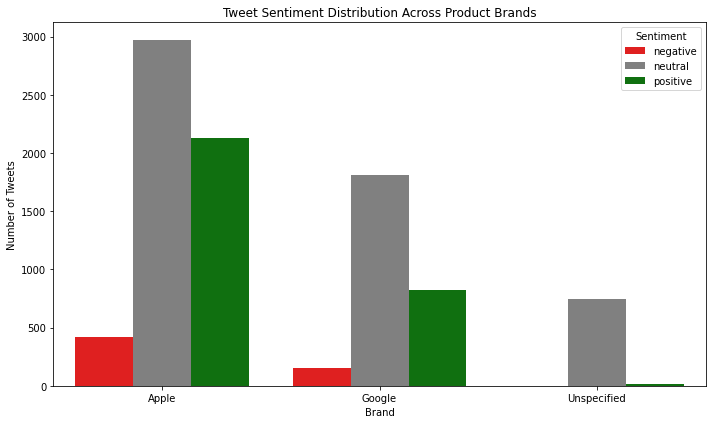

<Figure size 432x288 with 0 Axes>

In [20]:
#plot sentiment distribution by brand
#groupby and aggregate for plot
sentiment_by_brand = data.groupby(['brand', 'sentiment']).size().reset_index(name='count')

#define brand_order and colors for sentiments
brand_order = ['Apple', 'Google', 'Unspecified']
sentiment_palette = {'positive': 'green', 'neutral': 'grey', 'negative': 'red'}


plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_by_brand, x='brand',y='count',hue='sentiment', palette=sentiment_palette, order=brand_order)
plt.title('Tweet Sentiment Distribution Across Product Brands')
plt.xlabel('Brand')
plt.ylabel('Number of Tweets')
plt.legend(title='Sentiment')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show();
#save bar plot
plt.savefig('sentiment_distribution.png')


- lots about sxsw (south by southwest)
- positive, neutral, negative sentiment
- tokenize tweet, then can loop through the tweet tokens to pick out product tokens and then impute product in columns where its missing